
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

{'rnn_size': 400, 'tsteps': 4, 'batch_size': 5}
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
{'rnn_size': 400, 'tsteps': 4, 'batch_size': 5}
Saved {} lines 226
Number of data examples: 214
Batch size for dataset 107


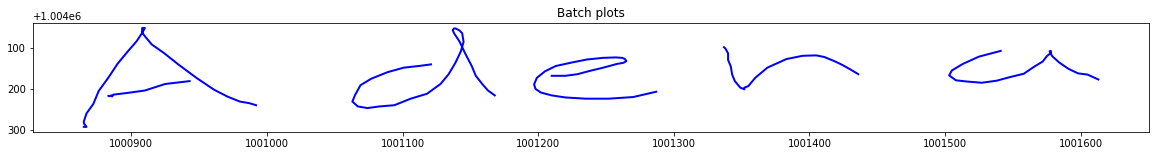

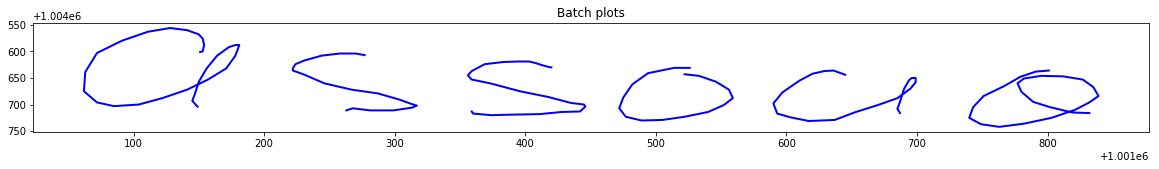

In [1]:
import numpy as np
import tensorflow as tf

import argparse
import time
import os


from LSTM import Model
import LSTM
from importlib import reload
reload(LSTM)
from dataloader import DataProcess

In [2]:
def init_args():
    
        args = {}
        args['rnn_size'] = 100 
        args['tsteps'] = 150 
        args['batch_size'] = 2 
        args['nmixtures'] = 8 
        args['alphabet'] = ' abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'
        args['tsteps_per_ascii'] = 25
        args['epochs'] = 100
        return args
    
def train_model():
    sess = tf.Session()
    data_loader = DataProcess()
    args = init_args()
    print("blah")
    print(args)
    model = Model(args)
    for epoch in range(args['epochs']):
        c0, c1, c2 = model.istate_cell0.c.eval(session=sess), model.istate_cell1.c.eval(session=sess), model.istate_cell2.c.eval(session=sess)
        h0, h1, h2 = model.istate_cell0.h.eval(session=sess), model.istate_cell1.h.eval(session=sess), model.istate_cell2.h.eval(session=sess)
        for bindex in range(args['batch_size']):
            i = epoch*args['batch_size'] + bindex
            start = time.time()
            x, y = data_loader.get_next_batch()
            y_placeholder = tf.placeholder(tf.float32, shape = [None, args['tsteps'], 3])
            input_data = tf.placeholder(dtype=tf.float32, shape=[None, args['tsteps'], 3])
            feed = {input_data: x, y_placeholder: y, \
                    model.istate_cell0.c: c0, model.istate_cell1.c: c1, model.istate_cell2.c: c2, \
                    model.istate_cell0.h: h0, model.istate_cell1.h: h1, model.istate_cell2.h: h2}
            loss = 1000000
            inputs = [tf.squeeze(input_, [1]) for input_ in tf.split(input_data, args['tsteps'], 1)]
            output0 = model.build_computational_graph(inputs, model.cell0, model.istate_cell0, "cell0")
            output0 = tf.convert_to_tensor(output0, dtype=tf.float32)
            output1 = model.build_computational_graph(inputs, model.cell1, model.istate_cell1, "cell1")
            output1 = tf.convert_to_tensor(output1, dtype=tf.float32)
            output2 = model.build_computational_graph(inputs, model.cell2, model.istate_cell2, "cell2")
            output2 = tf.convert_to_tensor(output2, dtype=tf.float32)
            flat_y_placeholder = tf.reshape(y_placeholder,[-1, 3])
            output2 = tf.reshape(tf.concat(output2, 1), [-1, 100]) #concat outputs for efficiency
            with tf.variable_scope("foo", reuse=tf.AUTO_REUSE):
                gd_w = tf.get_variable("out_w", [100, 3], initializer=model.graves_initializer)
                gd_b = tf.get_variable("out_b", [3], initializer=model.graves_initializer)
            output2 = tf.nn.xw_plus_b(output2, gd_w, gd_b)

            
#             output0 = tf.reshape(output0, [-1, args["rnn_size"]])
            with tf.name_scope("loss"):
                loss = tf.losses.mean_squared_error(labels=flat_y_placeholder, predictions=output2)
            with tf.variable_scope("foo", reuse=tf.AUTO_REUSE):
                optimizer = tf.train.AdamOptimizer(learning_rate=0.01,beta1=0.9, beta2=0.999).minimize(loss)
            init = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
            sess.run(init)
            
            [train_loss, _] = sess.run([loss, optimizer], feed)
            print("Running epoch:", epoch, "Train error:", train_loss)
            # print(len(inputs)) 
#             output = tf.contrib.legacy_seq2seq.rnn_decoder(inputs, initial_cell_state, cell, loop_function=None, scope=scope)
            
            
#             out0 = sess.run(model.build_computational_graph(x_placeholder, model.cell0, model.istate_cell0, "cell0"), feed_dict = {x_placeholder:x})
#             # out1, final_state1 = model.build_computational_graph(out0, model.cell1, model.istate_cell1, "cell1")
#             # out2, final_state2 = model.build_computational_graph(out1, model.cell2, model.istate_cell2, "cell2")
#             [train_loss, _] = sess.run([loss, model.optimizer], feed)
#             print("train_loss:",train_loss, "Epoch:", epoch)
            
    

In [3]:
train_model()

Saved {} lines 226
Number of data examples: 214
Batch size for dataset 107
blah
{'rnn_size': 100, 'tsteps': 150, 'batch_size': 2, 'nmixtures': 8, 'alphabet': ' abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ', 'tsteps_per_ascii': 25, 'epochs': 100}
{'rnn_size': 100, 'tsteps': 150, 'batch_size': 2, 'nmixtures': 8, 'alphabet': ' abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ', 'tsteps_per_ascii': 25, 'epochs': 100}
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Running epoch: 0 Train error: 1337.71
Running epoch: 0 Train error: 1211.5562
Running epoch: 1 Train error: 1196.1703
Running epoch: 1 Train error: 1462.7017
Running epoch: 2 Train error: 984.25555
Running epoch: 2 Train error: 1565.9408
Running epoch: 3 Train error: 739.6014
Running epoch: 3 Train error: 827.8804
Running epoch: 4 Train error: 1145.6084
Running epoch: 4 Train error: 705.78485
Running epoch: 5 Train error: 380.439


KeyboardInterrupt: 